In [1]:
!pip install camb
!pip install bayesflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.5 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [2]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import camb
from camb import model
import bayesflow as bf
from scipy.stats import truncnorm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-08-13 20:33:50.894180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755117231.083631      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755117231.144439      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755117245.009995      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
K_MIN, K_MAX, N_K = 1e-4, 1.0, 256
k_grid = np.logspace(np.log10(K_MIN), np.log10(K_MAX), N_K).astype(np.float32)

def simulate_pk(theta, z: float = 0.0, *, sigma_frac: float = 0.05, seed: int | None = None):
    """Generate power spectrum for cosmology with numerical stability"""
    rng = np.random.default_rng(seed)

    # Ensure numerical stability
    h = theta['H0'] / 100.0
    ombh2 = 0.02237
    omch2 = theta['Omega_m'] * h**2 - ombh2, 1e-5

    # CAMB setup with error handling
    try:
        pars = camb.CAMBparams()
        pars.set_accuracy(AccuracyBoost=2, lSampleBoost=2)                          # Accuracy boost
        pars.set_cosmology(H0=theta['H0'], ombh2=ombh2, omch2=omch2,
                           mnu=0.06, tau=0.0543)
        pars.InitPower.set_params(As=2.1e-9, ns=theta['n_s'])
        pars.set_matter_power(redshifts=[z], kmax=K_MAX*1.2, k_per_logint=30)
        pars.NonLinear = model.NonLinear_both                                       # Non-linear 
        pars.Transfer.high_precision = True                                         # Better precision

        pk_res = camb.get_matter_power_interpolator(                                # Interpolator
            pars, zs=[z], kmax=K_MAX*1.2, nonlinear=True,
            hubble_units=False, k_hunit=True
        )
        pk_interp = pk_res[0] if isinstance(pk_res, tuple) else pk_res

        # Calculate power spectrum with NaN protection
        P_nl = pk_interp.P(z, k_grid)
        if np.any(np.isnan(P_nl)):
            raise RuntimeError("NaN values in power spectrum")

        # Multiplicative noise preserves positivity
        noise = 1 + rng.normal(0.0, sigma_frac, P_nl.shape)
        noisyP = P_nl * noise

        return {'k': k_grid, 'P': noisyP.astype(np.float32)}

    except Exception as e:
        print(f"Error in CAMB: {e}")
        # Return fallback data with correct shape
        return {'k': k_grid, 'P': np.ones_like(k_grid) * 1e-10}                     # Return k-grid

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

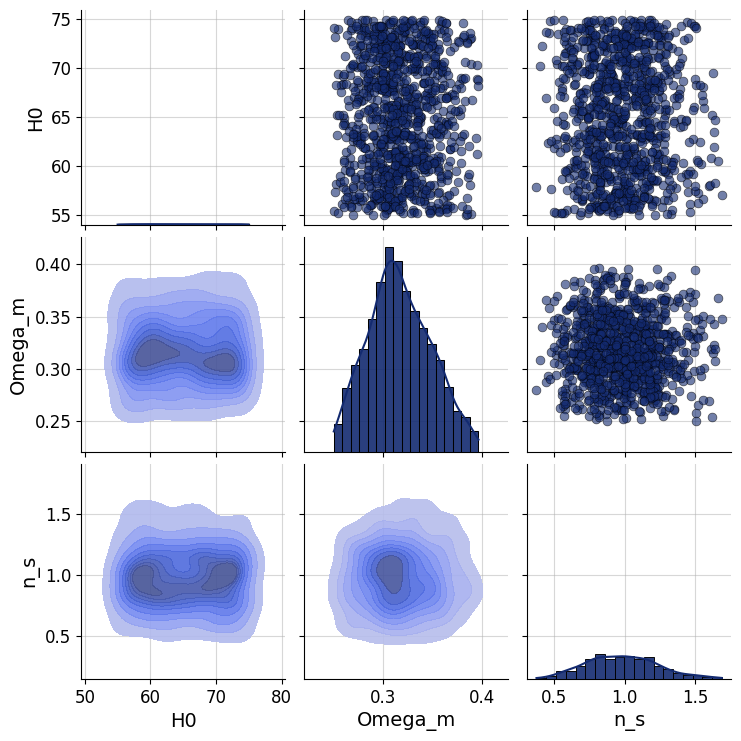

In [4]:
# ---- 2. BayesFlow simulator & wrappers -----------------------------

def prior():
    rng = np.random.default_rng()

    H0 = rng.uniform(55, 75)
    
    a_Om, b_Om = (0.25 - 0.315)/0.035, (0.40 - 0.315)/0.035
    Omega_m = truncnorm(a_Om, b_Om, loc=0.315, scale=0.035).rvs(random_state=rng)
    
    n_s = rng.gamma(shape=15, scale=1/15)
    while n_s < 0.3 or n_s > 1.7:
        n_s = rng.gamma(shape=15, scale=1/15)

    return dict(
        H0=np.float32(H0),
        Omega_m=np.float32(Omega_m),
        n_s=np.float32(n_s)
    )


def likelihood(H0, Omega_m, n_s, **kwargs):
    """Return a noisy matter power spectrum for the given cosmology."""
    theta = dict(H0=float(H0), Omega_m=float(Omega_m), n_s=float(n_s))
    return simulate_pk(theta)

# Sequential simulator
simulator = bf.make_simulator([prior, likelihood])


#-------------------- Plot for debugging -----------------------------
prior_samples = simulator.simulators[0].sample(1000)
grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["H0", "Omega_m", "n_s"]
)

In [5]:
# ----- Adapter, networks, approximator ------------------------ 
adapter = (
    bf.Adapter()
    .convert_dtype("float64", "float32")
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("P", "summary_variables")
    .log(["inference_variables", "summary_variables"], p1=True)
    .expand_dims("summary_variables", axis=-1)
)
       

# -------- Print the adapter structure for debugging --------
print(adapter)
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-5)   # AdamW optimizer

summary_net = bf.networks.TimeSeriesNetwork()                                  # Nueral network for summary 

inference_net = bf.networks.CouplingFlow()                                     # Nueral network for inference 

# Approximator 
approximator = bf.approximators.ContinuousApproximator( 
    adapter           = adapter,
    summary_network   = summary_net,
    inference_network = inference_net,
)

# Workflow to handle the pipeline 
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    optimizer=optimizer, 
    inference_network=inference_net,
    summary_network=summary_net,
    approximator=approximator,
    metrics=["loss"],
    standardise=None
)

Adapter([0: ConvertDType -> 1: Concatenate(['H0', 'Omega_m', 'n_s'] -> 'inference_variables') -> 2: Rename('P' -> 'summary_variables') -> 3: Log -> 4: ExpandDims])
Error in CAMB: must be real number, not tuple
Error in CAMB: must be real number, not tuple
(2, 256, 1)
(2, 3)


In [6]:
# Load the data
training_data = dict(np.load("/kaggle/input/wider-samples/train_wider_10000.npz"))
validation_data = dict(np.load("/kaggle/input/wider-samples/val.npz_wider_2000.npz"))

# Simulate data
# training_data = workflow.simulate(6000,num_workers=os.cpu_count()) # type: ignore
# validation_data = workflow.simulate(1200,num_workers=os.cpu_count()) # type: ignore

# Save simulated data
# np.savez_compressed("train.npz", **training_data)
# np.savez_compressed("val.npz", **validation_data)

In [7]:
history = workflow.fit_offline(
    data=training_data,
    epochs=150,
    batch_size=256,
    validation_data=validation_data,
    callbacks=[
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,          # Reduce LR by half
            patience=6,          # Wait 6 epochs with no improvement
            min_lr=1e-6,         # Minimum LR
            verbose=1,
        )
    ]
)

I0000 00:00:1755117252.821326      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 162ms/step - loss: 3.6200 - val_loss: 2.5778 - learning_rate: 5.0000e-04
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 2.3303 - val_loss: 1.7151 - learning_rate: 5.0000e-04
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 1.9365 - val_loss: 1.3008 - learning_rate: 5.0000e-04
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 1.6058 - val_loss: 1.1111 - learning_rate: 5.0000e-04
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 1.1723 - val_loss: 0.3878 - learning_rate: 5.0000e-04
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.6526 - val_loss: 0.5389 - learning_rate: 5.0000e-04
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.2054 - val_loss: 2.0622 - learning_rate: 5.0000e-04
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: -0.0276 - val_loss: -0.6405 - learning_rate: 5.0000e-04
Epoch 9/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: -0.2040 - val_loss: -0.5

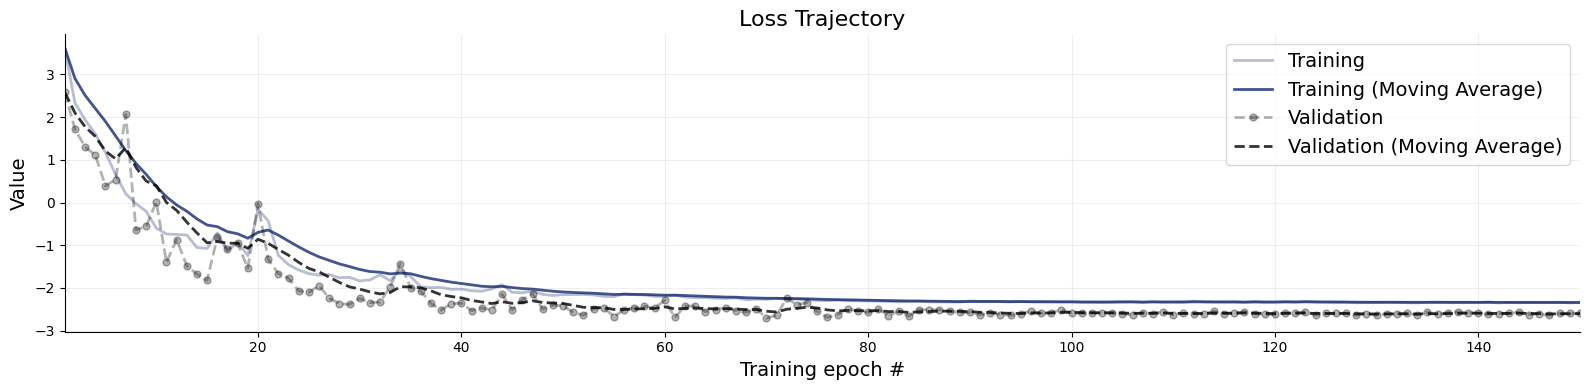

In [8]:
f = bf.diagnostics.plots.loss(history)

In [9]:
# Test data 
test_sims=dict(np.load("/kaggle/input/wider-samples/test.npz"))


# Simulate test data
# test_sims = workflow.simulate(200,num_workers=os.cpu_count())

# Save validated data
# np.savez_compressed("test.npz", **test_sims)

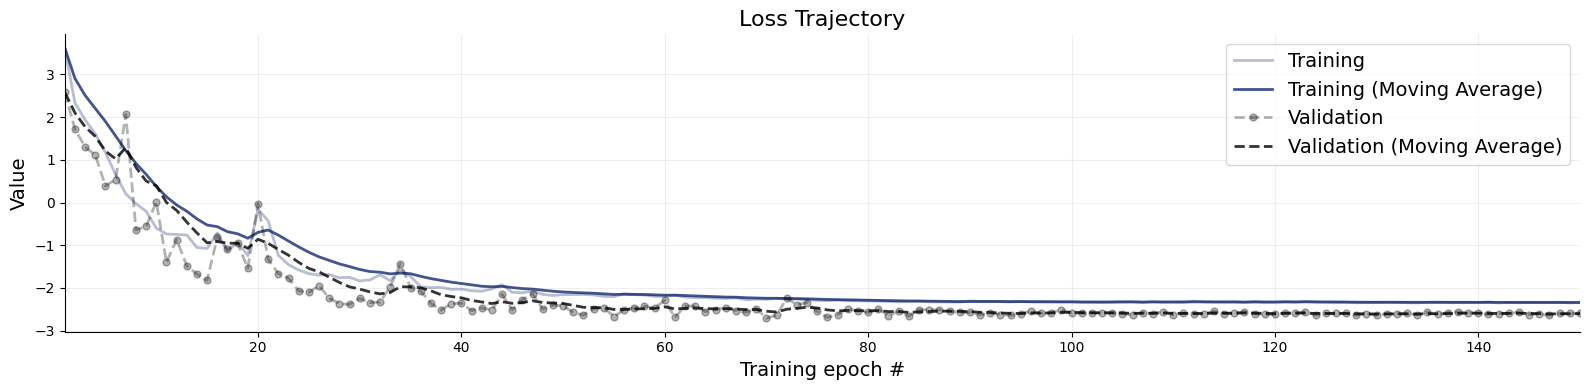

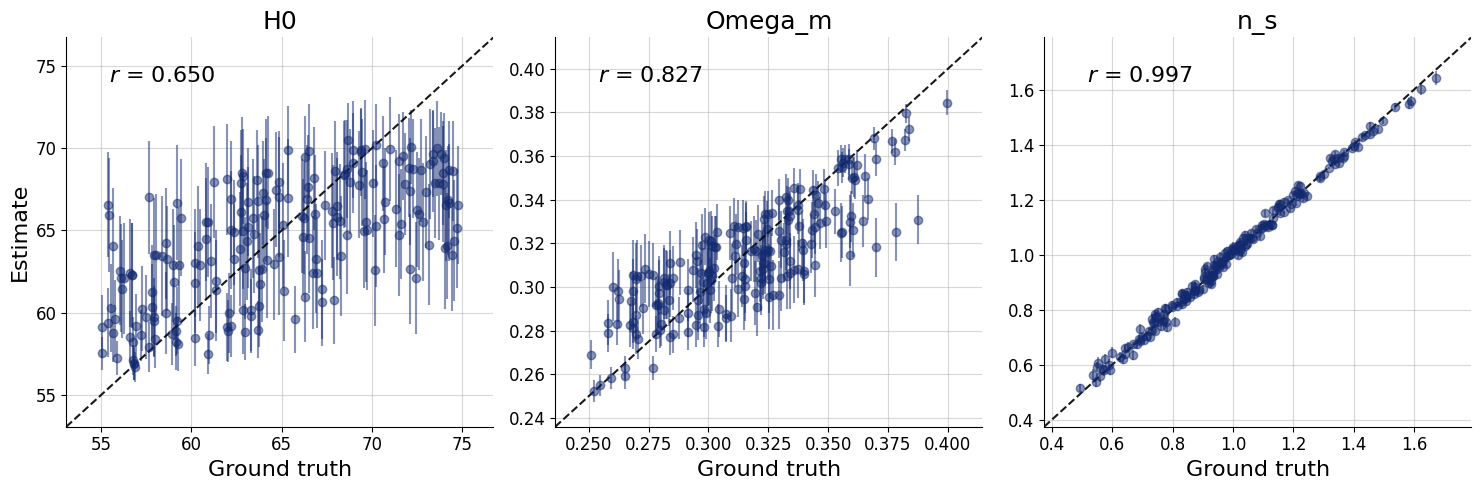

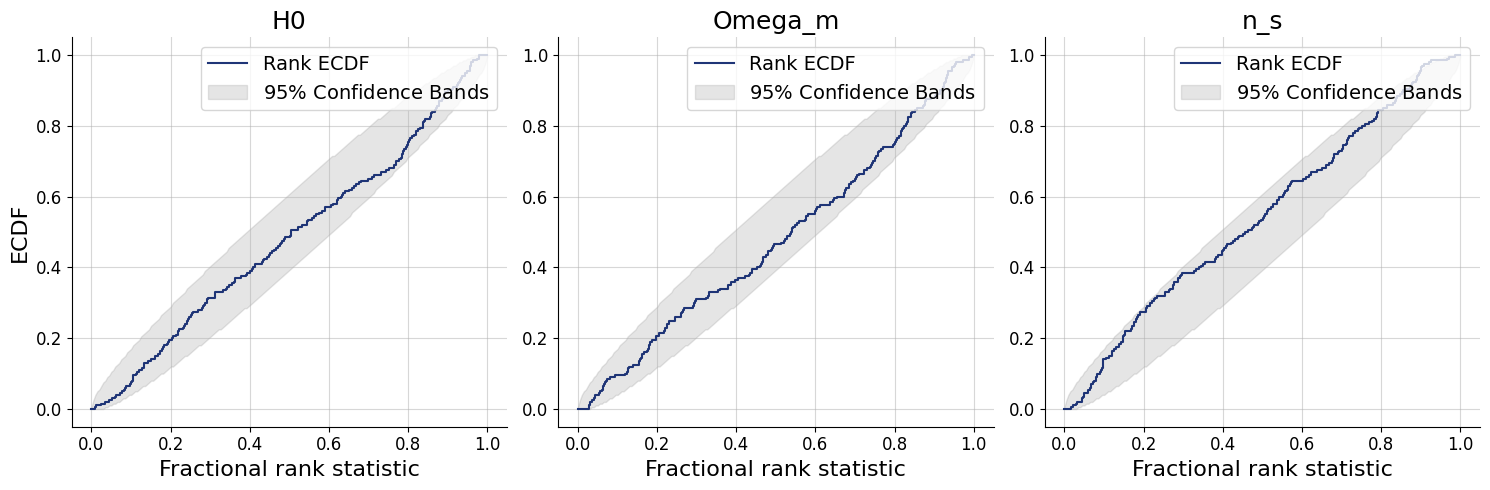

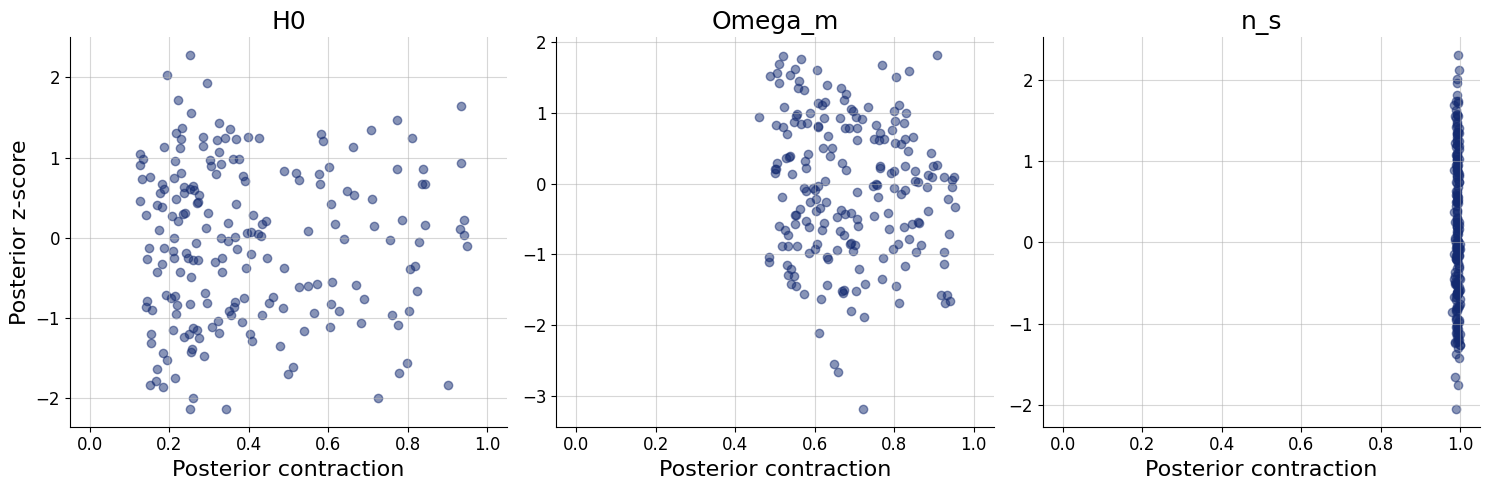

In [10]:
diagnostics=workflow.plot_default_diagnostics(test_data=test_sims)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

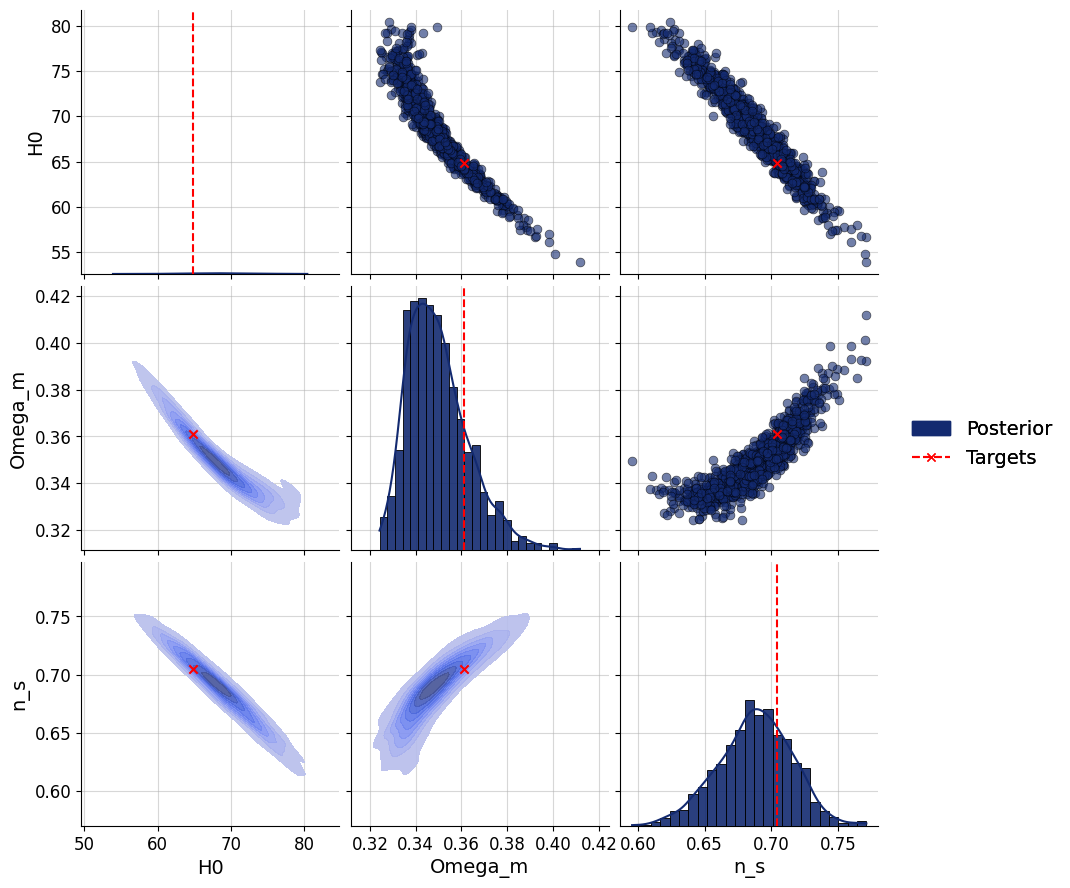

In [11]:
num_samples=1000
post_draws = workflow.sample(conditions=test_sims, num_samples=num_samples)
par_names = ["H0", "Omega_m", "n_s"]
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=test_sims,
    dataset_id=0,
    variable_names=par_names,
)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


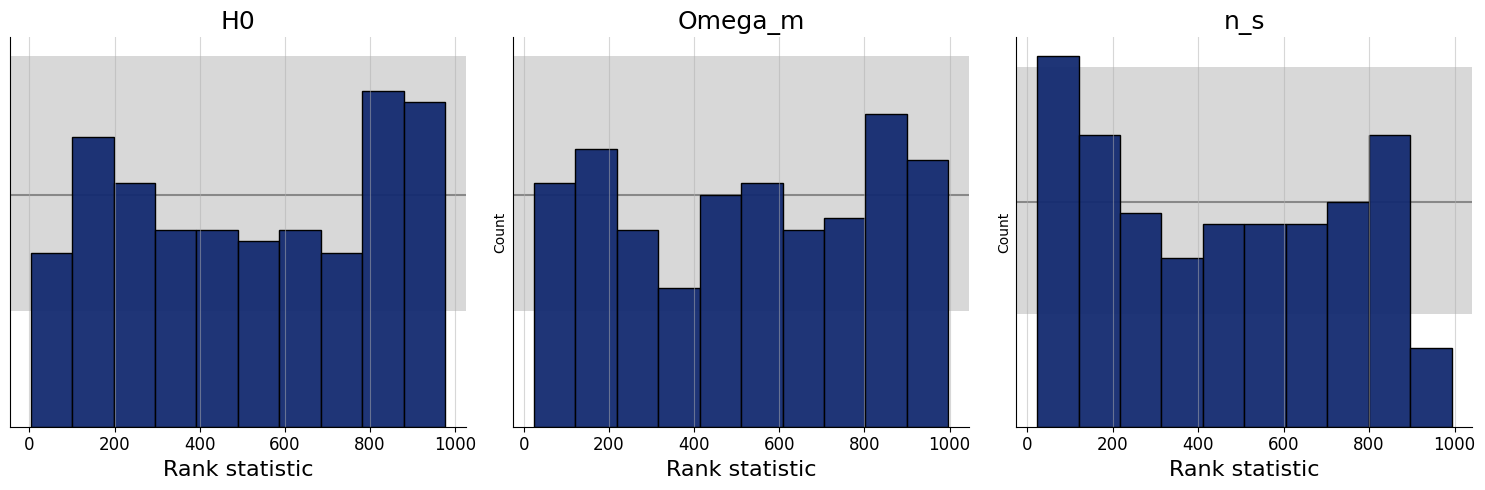

In [12]:
f = bf.diagnostics.plots.calibration_histogram(
    estimates= post_draws,
    targets=test_sims,
    variable_names=par_names
)

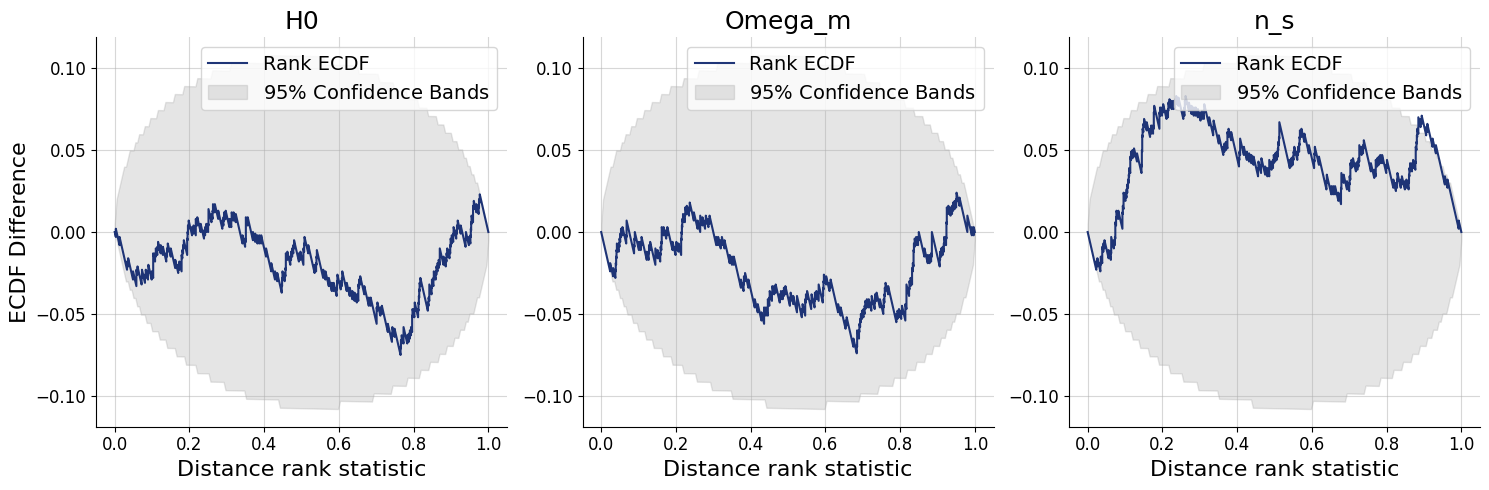

In [13]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=test_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

In [14]:
metrics = workflow.compute_default_diagnostics(test_data=test_sims)
metrics

,H0,Omega_m,n_s
NRMSE,0.321020,0.176362,0.024868
Posterior Contraction,0.334115,0.664863,0.992609
Calibration Error,0.024474,0.021447,0.034079


In [15]:
theta_true = dict(H0=68.0, Omega_m=0.32, n_s=0.965)
obs_pk = simulate_pk(theta_true)["P"].astype("float32")  

conds = {"summary_variables": obs_pk[None, :, None]}     

posterior = workflow.sample(
    conditions   = conds,
    num_samples  = num_samples, 
)

df_samples = workflow.samples_to_data_frame(posterior)
print(df_samples.head(5))


Error in CAMB: must be real number, not tuple
          H0   Omega_m       n_s
0  64.868805  0.212588  0.450235
1  57.345955  0.246956  1.498660
2  58.891125  0.173759  1.388321
3  45.132359  0.135430  1.328867
4  55.748978  0.201402  1.652495
